In [1]:
import torch, pickle, time, os, random
import numpy as np
import os.path as osp
import matplotlib.pyplot as plt
import torch_geometric as tg
from torch_geometric.loader import DataLoader
# accelerate huggingface to GPU
if torch.cuda.is_available():
    from accelerate import Accelerator
    accelerator = Accelerator()
    device = accelerator.device

torch.manual_seed(42)
random.seed(42)

In [2]:
cols_t=['mstar stellar mass [1.0E09 Msun](0)',
 ' v_disk rotation velocity of disk [km/s] (1)',
 ' r_bulge 3D effective radius of bulge [kpc](2)',
 ' mcold cold gas mass in disk [1.0E09 Msun](3)',
 ' mHI cold gas mass [1.0E09 Msun](4)',
 ' mH2 cold gas mass [1.0E09 Msun](5)',
 ' mHII cold gas mass [1.0E09 Msun](6)',
 ' sfrave100myr SFR averaged over 100 Myr [Msun/yr](7)']

cols_t=['mstar stellar mass [1.0E09 Msun](0)',
 ' v_disk rotation velocity of disk [km/s] (1)',
 ' mcold cold gas mass in disk [1.0E09 Msun](3)',
 ' sfrave100myr SFR averaged over 100 Myr [Msun/yr](7)']

all_cols=np.array([0,2,4,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,35]+list(range(37,60)))
targets=[8,11,14,15,16,17,18,23]
targets=[8,11,15,23]

In [3]:
os.listdir(osp.expanduser('~/../../../scratch/gpfs/cj1223/GraphStorage/'))

['vlarge_all_multit_z0.0_standard_stand',
 'medium_beforeafter',
 'medium_redshift_50_all',
 'vlarge_all_multit_z0.5_power_quant',
 'vlarge_all_multit_z0.0_None',
 'vlarge_all_multit_z2.0_standard_quant',
 'medium_smass_z1.0_standard',
 'vlarge_all_multisimple_z0.0_quantile_quant',
 'test_onlyhmass_smass',
 'medium_redshift_80_all',
 'vlarge_all_final',
 'vlarge_all_multit_z1.0_standard_stand',
 'vlarge_all_multit_z1.0_power_quant',
 'medium_all_q_diffbeforeafter',
 'vlarge_redshift_85_all',
 'vlarge_all_multi_z0.5_quantile',
 'medium_all_smass',
 'medium_onlyhmass_smass',
 'vlarge_all_multi_z1.0_power',
 'vlarge_all_multit_z0.0_quantile_quant',
 'vlarge_all_multit_z0.0_standard_quant',
 'vlarge_all_multit_z0.5_quantile_quant',
 'vlarge_all_multit_z0.0_quantile_raw',
 'medium_scaleonly_smass',
 'vlarge_all_multi_z0.5_None',
 'vlarge_all_multit_z2.0_None',
 'vlarge_all_multit_z1.0_standard_quant',
 'vlarge_all_multit_z0.0_power_quant',
 'vlarge_all_multi_z0.5_standard',
 'vlarge_redshif

In [4]:
# case='vlarge_all_multit_z0.0_quantile_quant'
case='vlarge_all_mul_z0.0_quantile_quant'
case='vlarge_all_multisimple_z0.0_quantile_raw'



datat=pickle.load(open(osp.expanduser(f'~/../../../scratch/gpfs/cj1223/GraphStorage/{case}/data.pkl'), 'rb'))

In [5]:
data=datat

In [6]:
ys=[]
for d in datat:
    ys.append(d.y.numpy())
ys=np.vstack(ys)

In [7]:
ys.shape

(108808, 3)

In [8]:
# k=3
# plt.hist(ys[:,k], bins=100);
# max(ys[:,k]), min(ys[:,k])

In [9]:
n_targ=len(data[0].y)
n_feat=len(data[0].x[0])
n_feat

43

In [10]:
import torch.nn.functional as F
from torch.nn import Linear, BatchNorm1d, LayerNorm, ModuleList
from torch_geometric.nn import SAGEConv, global_mean_pool, norm, global_max_pool, global_add_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, n_lin=2, n_feat=1, n_targ=1):
        super(GCN, self).__init__()
        self.n_targ = n_targ
        self.n_feat = n_feat
        self.n_lin = n_lin
        self.conv1 = SAGEConv(n_feat, hidden_channels) ##use meta-layer
        ## https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.meta.MetaLayer
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.conv4 = SAGEConv(hidden_channels, hidden_channels)
        self.conv5 = SAGEConv(hidden_channels, hidden_channels)
        
        
#         self.norm = LayerNorm(normalized_shape=hidden_channels) # layer_norm instead
        self.decoders = ModuleList()
        self.norms = ModuleList()
        for _ in range(n_targ):
            self.decoder=ModuleList()
            self.norm=ModuleList()
            for i in range(n_lin):
                if i==n_lin-1:
                    self.norm.append(LayerNorm(normalized_shape=hidden_channels))
                    self.decoder.append(Linear(hidden_channels, 1))
                else:
                    self.norm.append(LayerNorm(normalized_shape=hidden_channels))
                    self.decoder.append(Linear(hidden_channels, hidden_channels))
            self.decoders.append(self.decoder)
            self.norms.append(self.norm)
#         self.lin1 = Linear(hidden_channels, n_targ)
        
    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)
        x = x.relu()
        x = self.conv5(x, edge_index)
        x = x.relu()
        x = global_add_pool(x, batch)  ## Miles says use sumpool
        
        x_out=[]
        for norm, decode in zip(self.norms, self.decoders):# x = self.lin1(self.norm(x))
#             print(norm, decode)
            x1=torch.clone(x)
            for n, d in zip(norm, decode):
                x1=d(n(x1))
#                 print(x1.shape)
            x_out.append(x1)
        x=torch.cat(x_out, dim=1)
        return x
    
model = GCN(hidden_channels=64)
next(model.parameters()).is_cuda ##check number one

False

In [11]:
criterion = torch.nn.MSELoss()
n_epochs=20
n_trials=1
batch_size=128
split=0.8
test_data=data[int(len(data)*split):]
train_data=data[:int(len(data)*split)]
l1_lambda = 1e-5
l2_lambda = 1e-5

In [12]:
trains, tests, scatter = [], [], []
yss, preds=[],[]
model = GCN(hidden_channels=64, n_feat=n_feat, n_targ=n_targ)
train_loader=DataLoader(train_data, batch_size=batch_size, shuffle=1, num_workers=4)
test_loader=DataLoader(test_data, batch_size=batch_size, shuffle=0,num_workers=4)    
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
_, _, test_loader = accelerator.prepare(model, optimizer, test_loader)
model, optimizer, train_loader = accelerator.prepare(model, optimizer, train_loader)
print('GPU ', next(model.parameters()).is_cuda)

# Initialize our train function

def train():
    model.train()
    global out
    for data in train_loader:  
        out = model(data.x, data.edge_index, data.batch)  
        loss = criterion(out, data.y.view(-1,n_targ)) 
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())


        loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm
#             loss.backward()
        accelerator.backward(loss)
        optimizer.step() 
        optimizer.zero_grad() 
#     print(loss, l1_norm*l1_lambda, l2_norm*l2_lambda)
 # test function

def test(loader): ##### transform back missing
    model.eval()
    outs = []
    ys = []
    with torch.no_grad(): ##this solves it!!!
        for dat in loader: 
            out = model(dat.x, dat.edge_index, dat.batch) 
            ys.append(dat.y.view(-1,n_targ))
            outs.append(out)
    outss=torch.vstack(outs)
    yss=torch.vstack(ys)
    return torch.std(outss - yss, axis=0), outss, yss

/home/cj1223/.conda/envs/juptorch/lib/python3.9/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


GPU  True


In [13]:
#this uses about 1 GB of memory on the GPU
tr_acc, te_acc = [], []
start=time.time()
for epoch in range(n_epochs):

    train()

    if (epoch+1)%2==0:
        train_acc, _ , _ = test(train_loader)
        test_acc, _ , _ = test(test_loader)
        tr_acc.append(train_acc)
        te_acc.append(test_acc)
        print(f'Epoch: {epoch+1:03d}, Train scatter: {np.round(train_acc.cpu().numpy(), 4)} \n \
          Test scatter:  {np.round(test_acc.cpu().numpy(), 4)}')
stop=time.time()
spent=stop-start
print(f"{spent:.2f} seconds spent training, {spent/n_epochs:.3f} seconds per epoch. Processed {len(data)*split*n_epochs/spent:.0f} trees per second")


Epoch: 002, Train scatter: [0.1372 0.0502 0.291 ] 
           Test scatter:  [0.1353 0.0494 0.3124]
Epoch: 004, Train scatter: [0.1371 0.0493 0.2811] 
           Test scatter:  [0.1357 0.0485 0.318 ]
Epoch: 006, Train scatter: [0.1392 0.048  0.2623] 
           Test scatter:  [0.1458 0.0469 0.3016]
Epoch: 008, Train scatter: [0.1256 0.044  0.2559] 
           Test scatter:  [0.1258 0.0441 0.291 ]
Epoch: 010, Train scatter: [0.1276 0.044  0.2584] 
           Test scatter:  [0.1322 0.0431 0.3017]
Epoch: 012, Train scatter: [0.1311 0.045  0.2571] 
           Test scatter:  [0.1423 0.0456 0.32  ]
Epoch: 014, Train scatter: [0.12   0.0439 0.2442] 
           Test scatter:  [0.1251 0.0441 0.3083]
Epoch: 016, Train scatter: [0.1141 0.0425 0.2358] 
           Test scatter:  [0.1163 0.0422 0.3051]
Epoch: 018, Train scatter: [0.1169 0.042  0.2375] 
           Test scatter:  [0.1185 0.042  0.3003]
Epoch: 020, Train scatter: [0.1146 0.0435 0.2321] 
           Test scatter:  [0.1164 0.0454 0.3258]


In [14]:
trainstd, outtrain, ytrain = test(train_loader)

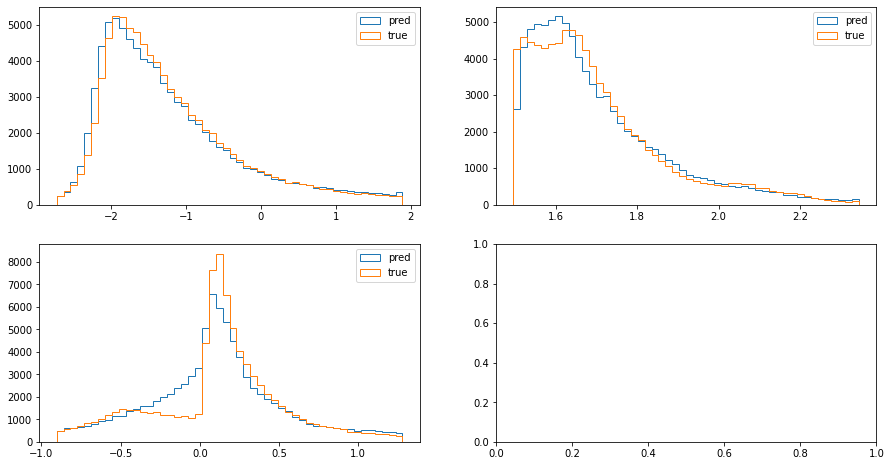

In [15]:
fig , ax = plt.subplots(2,2, figsize=(15,8))
ax = ax.flatten()
l=0.5
for k in range(n_targ):
#     ax[k].hist(ress.cpu().numpy()[:,k], bins=50, histtype='step', label='res')
    ax[k].hist(outtrain.cpu().numpy()[:,k], bins=50, \
            range=list(np.percentile(outtrain.cpu().numpy()[:,k], [l,100-l])), histtype='step', label='pred')
    ax[k].hist(ytrain.cpu().numpy()[:,k], bins=50, \
            range=list(np.percentile(outtrain.cpu().numpy()[:,k], [l,100-l])), histtype='step', label='true')

    ax[k].legend()
#     print(np.std(ress.cpu().numpy()[:,k]), np.mean(ress.cpu().numpy()[:,k]))

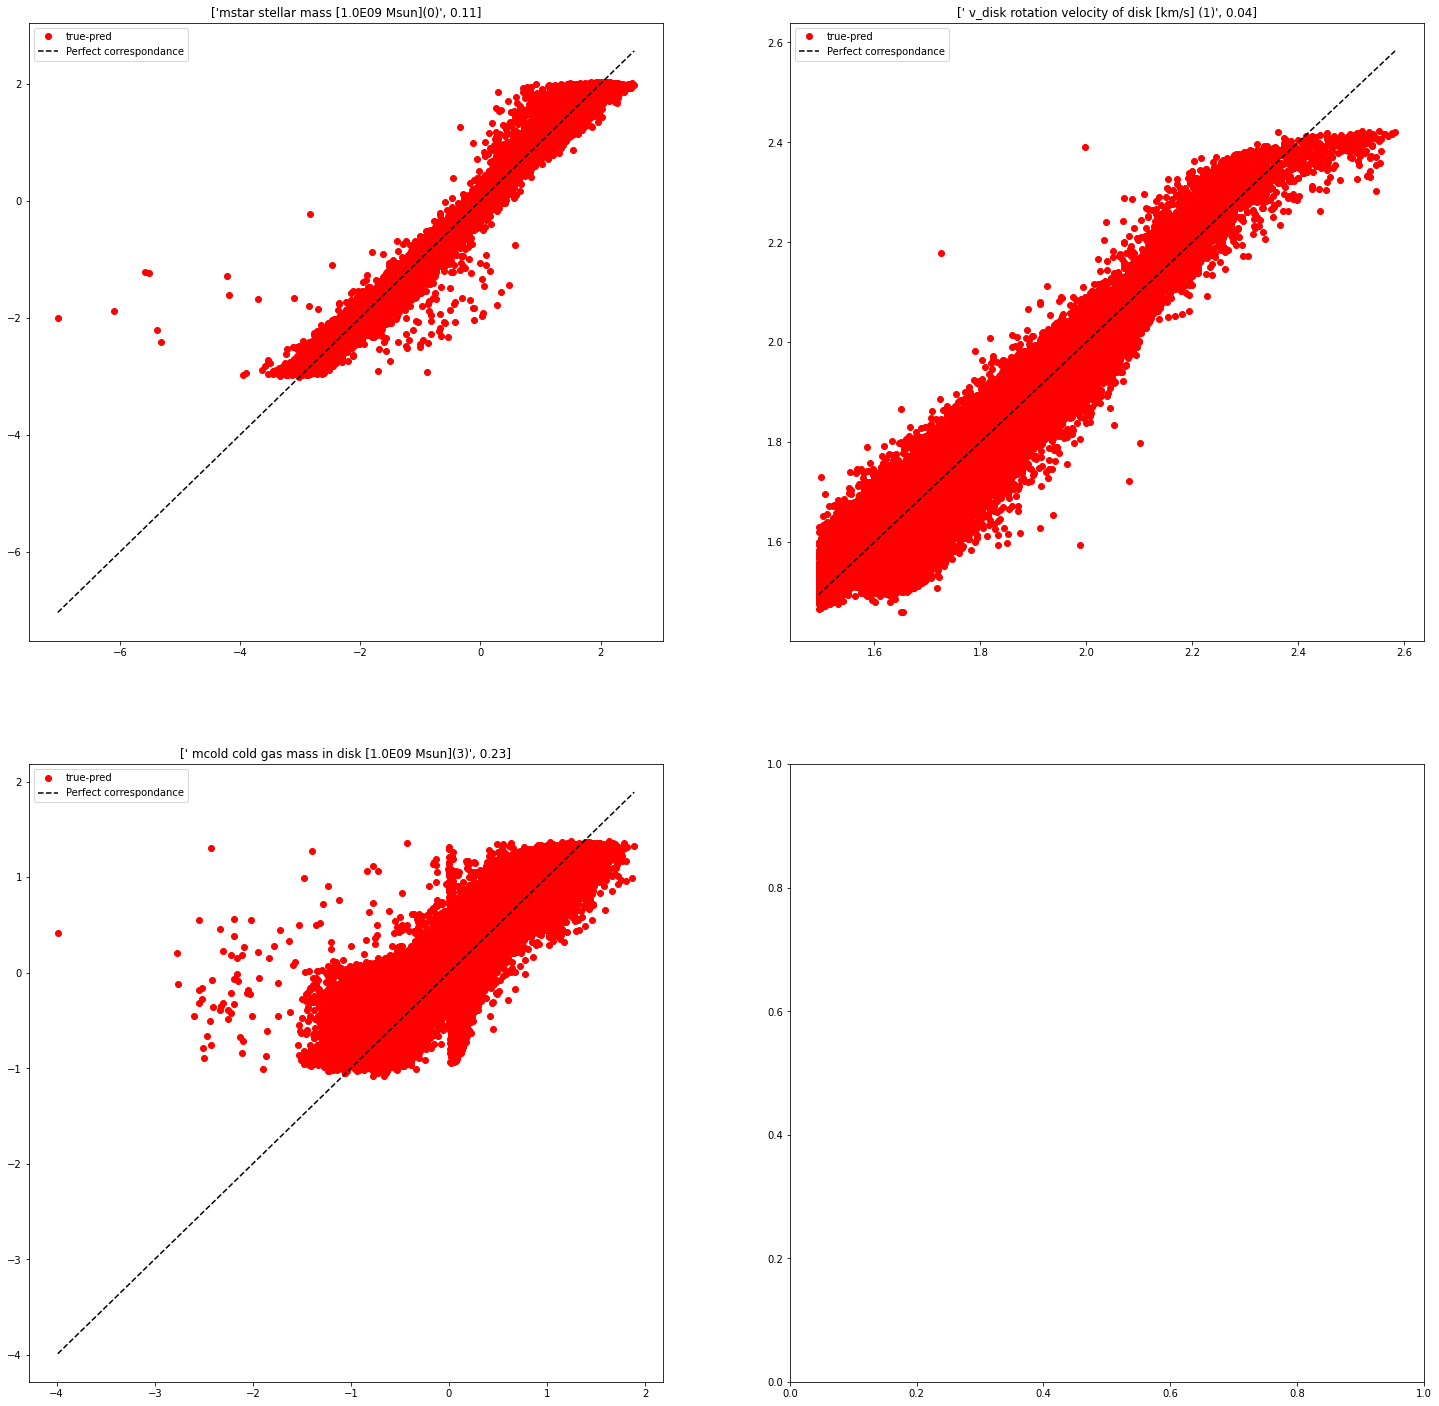

In [16]:
fig , ax = plt.subplots(2,2, figsize=(25,25))
ax = ax.flatten()
l=0.5
for k in range(n_targ):
    ytr=ytrain.cpu().numpy()[:,k]
    predtr=outtrain.cpu().numpy()[:,k]
    ax[k].plot(ytr, predtr, 'ro', label='true-pred')
    ax[k].plot([min(ytr),max(ytr)],[min(ytr),max(ytr)], 'k--', label='Perfect correspondance')
    ax[k].set(title=[cols_t[k], np.round(np.std(ytr-predtr),2)])
    ax[k].legend()
#     print(np.std(ress.cpu().numpy()[:,k]), np.mean(ress.cpu().numpy()[:,k]))

In [17]:
teststd, outtest, ytest = test(train_loader)

/home/cj1223/.conda/envs/juptorch/lib/python3.9/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


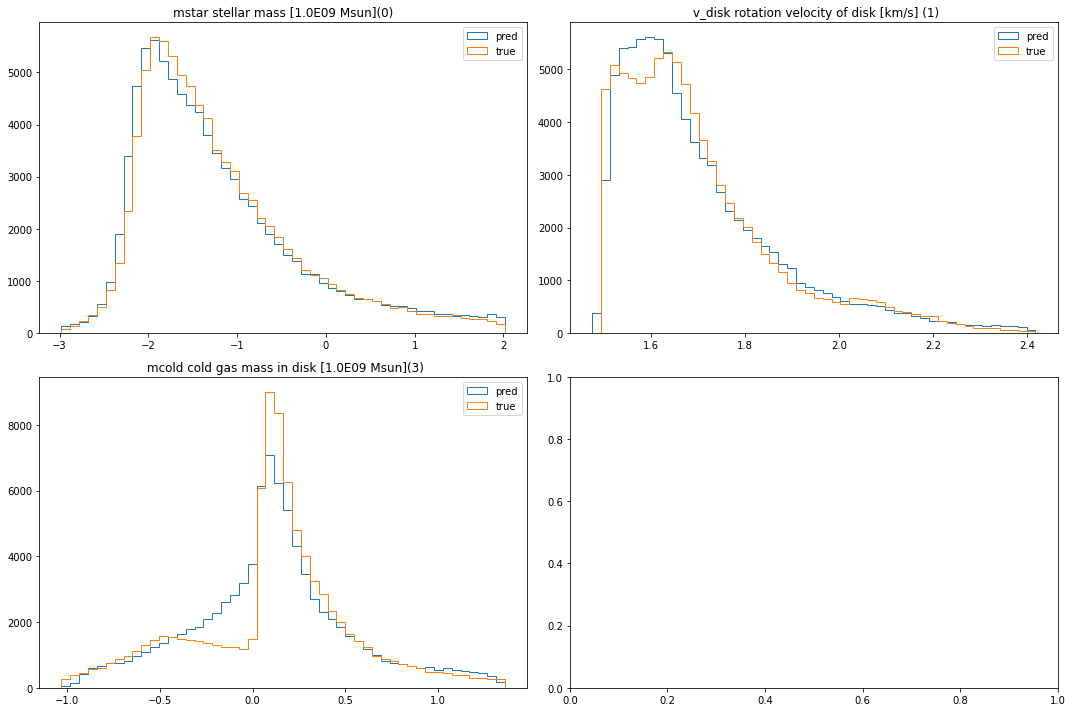

In [18]:
fig , ax = plt.subplots(2,2, figsize=(15,10))
ax = ax.flatten()
l=0.01
for k in range(n_targ):
    ax[k].hist(outtest.cpu().numpy()[:,k], bins=50, \
            range=list(np.percentile(outtest.cpu().numpy()[:,k], [l,100-l])), histtype='step', label='pred')
    ax[k].hist(ytest.cpu().numpy()[:,k], bins=50, \
            range=list(np.percentile(outtest.cpu().numpy()[:,k], [l,100-l])), histtype='step', label='true')
    ax[k].set(title=cols_t[k])
    ax[k].legend()
#     print(np.std(ress.cpu().numpy()[:,k]), np.mean(ress.cpu().numpy()[:,k]))
fig.tight_layout()

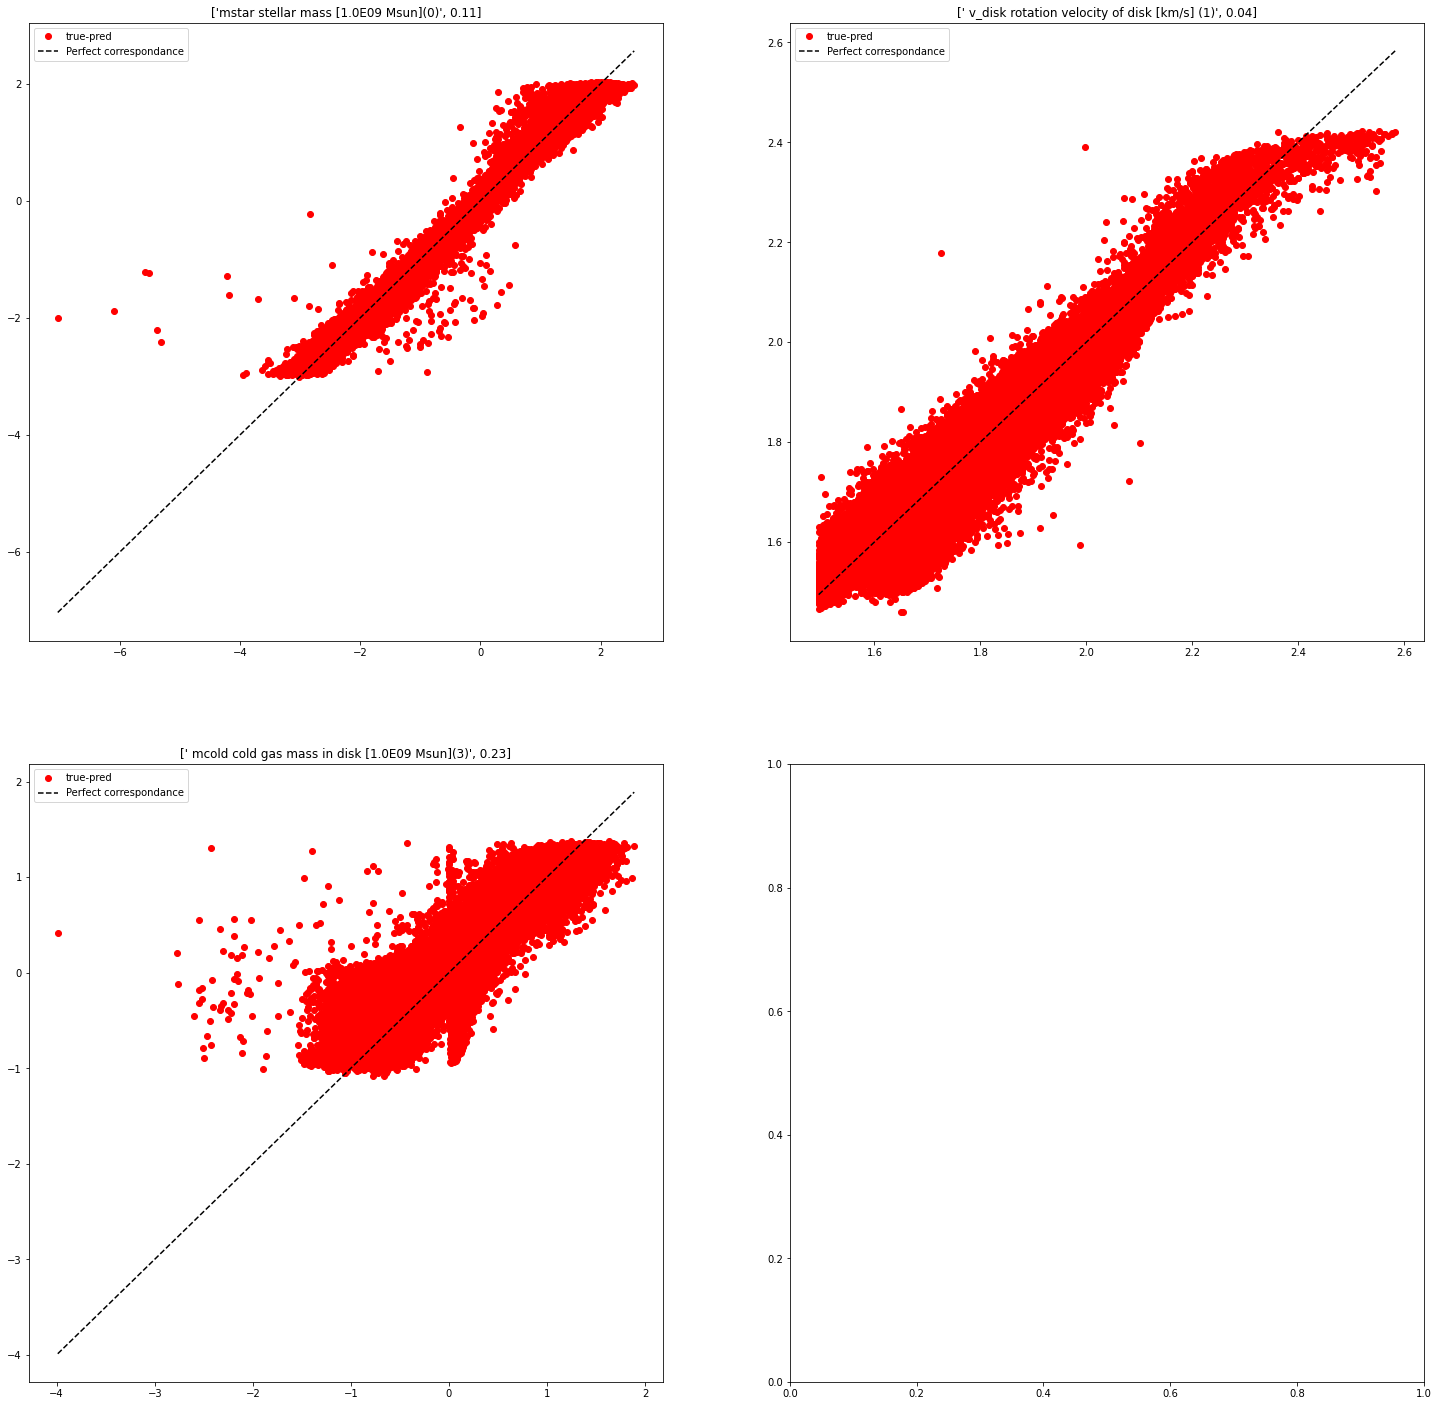

In [19]:
fig , ax = plt.subplots(2,2, figsize=(25,25))
ax = ax.flatten()
for k in range(n_targ):
    yte=ytest.cpu().numpy()[:,k]
    predte=outtest.cpu().numpy()[:,k]
    ax[k].plot(yte, predte, 'ro', label='true-pred')
    ax[k].plot([min(yte),max(yte)],[min(yte),max(yte)], 'k--', label='Perfect correspondance')
    ax[k].set(title=[cols_t[k], np.round(np.std(yte-predte),2)])
    ax[k].legend()
#     print(np.std(ress.cpu().numpy()[:,k]), np.mean(ress.cpu().numpy()[:,k]))

In [20]:
transform='quantile'
transform_path=osp.expanduser(f"~/../../../scratch/gpfs/cj1223/GraphStorage/transformers/{transform}_alltarg_1.pkl")
target_scaler=pickle.load(open(transform_path, 'rb'))

transform_path=osp.expanduser(f"~/../../../scratch/gpfs/cj1223/GraphStorage/transformers/{transform}_allfeat_1.pkl")
feat_scaler=pickle.load(open(transform_path, 'rb'))

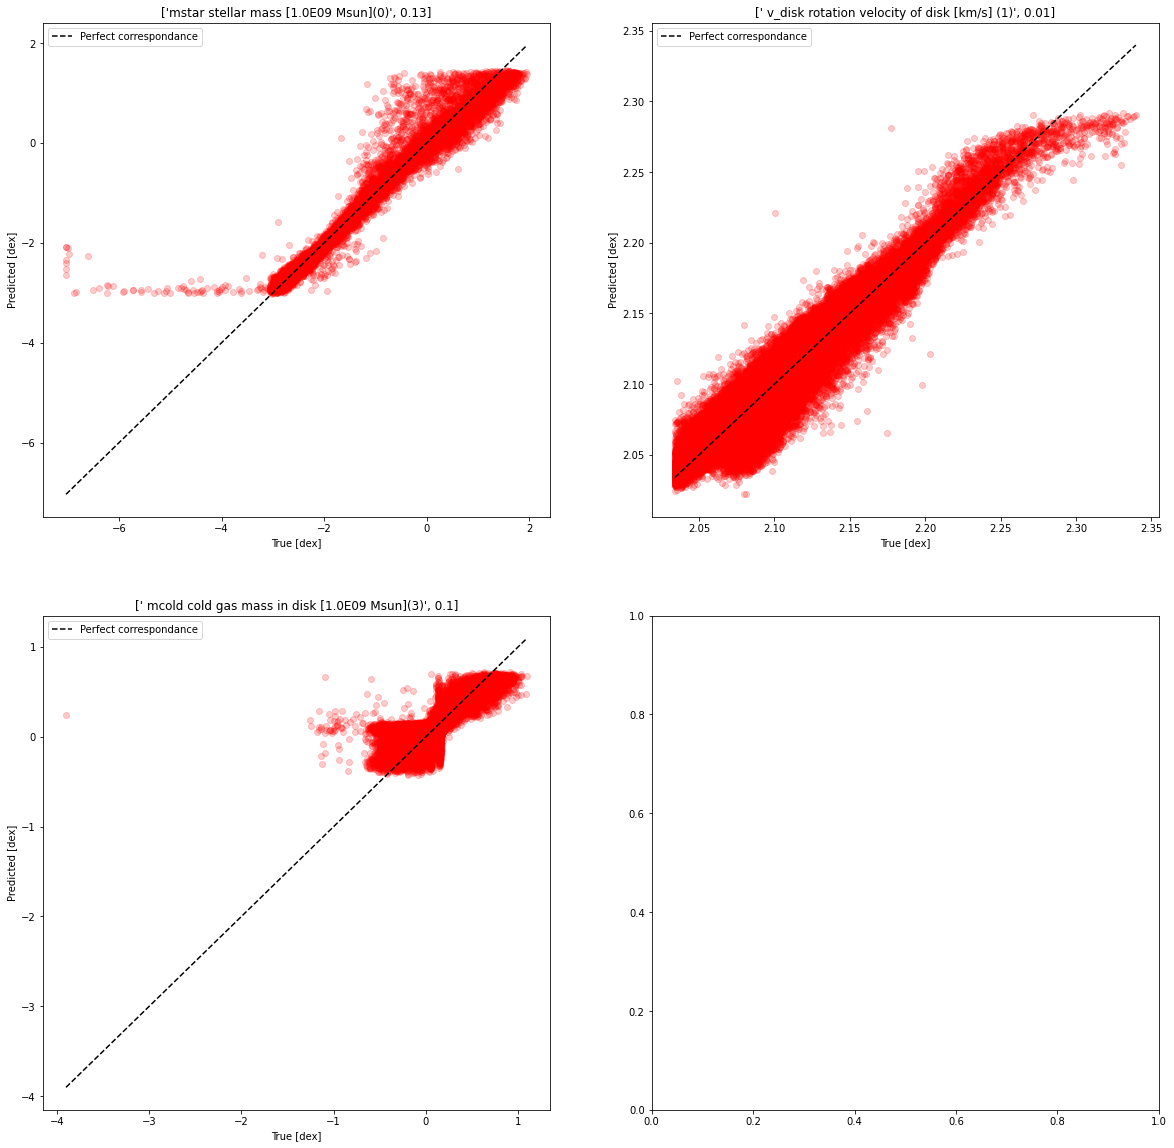

In [21]:
fig , ax = plt.subplots(2,2, figsize=(20,20))
ax = ax.flatten()
for k in range(n_targ):
    yte=np.hstack(target_scaler[targets[k]].inverse_transform(ytest.cpu().numpy()[:,k].reshape(-1,1)))
    predte=np.hstack(target_scaler[targets[k]].inverse_transform(outtest.cpu().numpy()[:,k].reshape(-1,1)))
    ax[k].plot(yte, predte, 'ro', alpha=0.2)
    ax[k].plot([min(yte),max(yte)],[min(yte),max(yte)], 'k--', label='Perfect correspondance')
    ax[k].set(title=[cols_t[k], np.round(np.std(yte-predte),2)], xlabel='True [dex]', ylabel='Predicted [dex]')
    ax[k].legend()